In [1]:
import numpy as np
from scipy.stats import spearmanr

def cohens_d(x, y):
    n1, n2 = len(x), len(y)
    s1, s2 = np.std(x, ddof=1), np.std(y, ddof=1)
    s_pooled = np.sqrt(((n1 -1)*s1**2 + (n2 -1)*s2**2) / (n1 + n2 -2))
    d = (np.mean(x) - np.mean(y)) / s_pooled
    if d<=0.2:
        meaning = "Negligible"
    elif d>0.2 and d <=0.5:
        meaning="Small"
    elif d >0.5 and d <= 0.8:
        meaning = 'Moderate'
    elif d>0.8:
        meaning = 'Large'
    return d, meaning


def instability_index(x, y):
    rho, _ = spearmanr(x, y)
    instability_index = 1 - rho
    
    if instability_index<=0.05:
        meaning = "Very low" # "Very stable"
    elif instability_index>0.05 and instability_index <=0.15:
        meaning= "Low"# "Stable"
    elif instability_index >0.15 and instability_index <= 0.35:
        meaning = 'Moderate' # 'Moderate instability'
    elif instability_index >0.35 and instability_index <= 0.60:
        meaning = "High" # 'High instability'
    elif instability_index>0.6:
        meaning = "Very high" # 'Very unstable'
    
    return instability_index, meaning

import numpy as np
from scipy.stats import mannwhitneyu

def cliffs_delta_fast(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n_x = len(x)
    n_y = len(y)

    # Mann-Whitney U test (two-sided, but we just use U statistic)
    U, _ = mannwhitneyu(x, y, alternative='two-sided')
    # Compute delta
    delta = (2 * U) / (n_x * n_y) - 1
    abs_delta = abs(delta)

    if abs_delta < 0.147:
        meaning = "Negligible"
    elif abs_delta < 0.33:
        meaning = "Small"
    elif abs_delta < 0.474:
        meaning = "Medium"
    else:
        meaning = "Large"
    
    return abs_delta, meaning


from scipy.stats import kendalltau

def ordinal_ranking_instability(x, y):
    tau, _ = kendalltau(x, y)
    instability = 1 - tau
    if instability <= 0.05:
        meaning = "Very low"
    elif instability <= 0.15:
        meaning = "Low"
    elif instability <= 0.35:
        meaning = "Moderate"
    elif instability <= 0.60:
        meaning = "High"
    else:
        meaning = "Very high"
    return instability, meaning

# all_events_all_res = pd.concat([all_events_df_5mins_raw, all_events_df_10mins_raw], axis=1)
# all_events_all_res_columns = all_events_all_res.columns
# standard_scaler = MinMaxScaler()
# transformed_scaled = standard_scaler.fit_transform(all_events_all_res[all_events_all_res_columns])
# transformed_scaled = pd.DataFrame(transformed_scaled, columns=all_events_all_res_columns)

# Example for one metric
# for metric in metric_columns:
#     print(f"{metric}")
#     metric_fine = transformed_scaled[f"{metric}_5m"]
#     metric_coarse = transformed_scaled[f"{metric}_10m"]
#     for res in ['10m', '30m', '60m']:
#         metric_coarse = transformed_scaled[f"{metric}_{res}"]
#         d, meaning = cohens_d(metric_fine, metric_coarse)
#         instab, translation = instability_index(metric_fine, metric_coarse)
#         print(f"{res}: Sensitivity of event rankings to DMC transformation (Cohen's D): {meaning} ({d:.2f}).  \n{res} Sensitivity of event numerical meanings to DMC transformation (instability_index): {translation} ({instab:.2f}) ")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm
from scipy.interpolate import interp1d
# import seaborn as sns
import os
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import ks_2samp
import pickle
import datetime 
import warnings
import sys
from datetime import timedelta
warnings.simplefilter(action='ignore', category=FutureWarning)

# from ClassFunctions_OtherRes import precip_time_series, rainfall_analysis
sys.path.insert(0, '../')
from PlottingFunctions import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
# all_events_5mins =[]
# all_events_10mins =[]
# all_events_30mins =[]
# all_events_60mins =[]

# total_events = 0
# print(len(os.listdir("../../DanishRainData_Outputs/5mins/")))

# for num, file in enumerate(np.sort(os.listdir("../../DanishRainData_Outputs/5mins/"))):
#     if file != "All_events_571820_precip_minute.csv":
#         # Get 5 mintue data
#         df_5m = pd.read_csv(f"../../DanishRainData_Outputs/5mins/{file}")
#         df_5m['event_num']=df_5m.index
#         # Get rid of the trailing strings sometimes on the gauge_num
#         df_5m['gauge_num'] = df_5m['gauge_num'].apply(
#             lambda x: int(x.split('_')[0]) if isinstance(x, str) and x.split('_')[0].isdigit() else x)

#         # Get other resolution data
#         df_10m = pd.read_csv(f"../../DanishRainData_Outputs/{10}mins/{file}")
#         df_30m = pd.read_csv(f"../../DanishRainData_Outputs/{30}mins/{file}")
#         df_60m = pd.read_csv(f"../../DanishRainData_Outputs/{60}mins/{file}")

#        # Find common event numbers in all four
#         common_event_nums = (
#             set(df_5m['event_num']) &
#             set(df_10m['event_num']) &
#             set(df_30m['event_num']) &
#             set(df_60m['event_num']))

#         # Filter all DataFrames to only include common events
#         df_5m = df_5m[df_5m['event_num'].isin(common_event_nums)].reset_index(drop=True)
#         df_10m = df_10m[df_10m['event_num'].isin(common_event_nums)].reset_index(drop=True)
#         df_30m = df_30m[df_30m['event_num'].isin(common_event_nums)].reset_index(drop=True)
#         df_60m = df_60m[df_60m['event_num'].isin(common_event_nums)].reset_index(drop=True)

#         total_events = total_events + len(common_event_nums)
#         print(f"{num} : {file}: {len(common_event_nums)} events retained across all resolutions, new total: {total_events}")    

#         # Collect DataFrames into a dictionary for easy iteration
#         dfs = {'5m': df_5m,
#             '10m': df_10m,
#             '30m': df_30m,
#             '60m': df_60m}

#         # Check the start and end times align
#         for i in range(len(df_5m)):
#             reference_start = pd.to_datetime(df_5m.iloc[i]['start_time'])
#             reference_end = pd.to_datetime(df_5m.iloc[i]['end_time'])
#             # print(reference_start,reference_end)
#             for res, df in dfs.items():
#                 start = pd.to_datetime(df.iloc[i]['start_time'])
#                 end = pd.to_datetime(df.iloc[i]['end_time'])
#                 #print(res, start, end)

#                 delta_start = abs(start - reference_start)
#                 delta_end = abs(end - reference_end)

#                 if delta_start > timedelta(minutes=60):
#                     print(f"⚠️ START mismatch in {res} at index {i}")
#                     print(f"   {res} start: {start}, 5m start: {reference_start}, Δ: {delta_start}")

#                 if delta_end > timedelta(minutes=60):
#                     print(f"⚠️ END mismatch in {res} at index {i}")
#                     print(f"   {res} end: {end}, 5m end: {reference_end}, Δ: {delta_end}")

#         all_events_5mins.append(df_5m)
#         all_events_10mins.append(df_10m)             
#         all_events_30mins.append(df_30m)
#         all_events_60mins.append(df_60m)            

# # all_events_df_5mins = pd.concat(all_events_5mins)   
# # all_events_df_30mins = pd.concat(all_events_30mins)   
# # print(len(all_events_df_5mins), len(all_events_df_30mins))
# # all_events_df_30mins.reset_index(inplace=True,drop=True)

In [3]:
# all_events_df_5mins = pd.concat(all_events_5mins)   
# all_events_df_10mins = pd.concat(all_events_10mins)   
# all_events_df_30mins = pd.concat(all_events_30mins)
# all_events_df_60mins = pd.concat(all_events_60mins)   

# for df in [all_events_df_5mins, all_events_df_10mins, all_events_df_30mins, all_events_df_60mins]:
#     df.reset_index(drop=True, inplace=True)
    
# print(len(all_events_df_5mins), len(all_events_df_10mins), len(all_events_df_30mins), len(all_events_df_60mins))

364479 364479 364479 364479


In [4]:
# all_events_df_5mins.to_csv('all_events_df_5mins.csv', index=False)
# all_events_df_10mins.to_csv('all_events_df_10mins.csv', index=False)
# all_events_df_30mins.to_csv('all_events_df_30mins.csv', index=False)
# all_events_df_60mins.to_csv('all_events_df_60mins.csv', index=False)


In [2]:
all_events_df_5mins = pd.read_csv('../../all_events_df_5mins.csv')
all_events_df_10mins = pd.read_csv('../../all_events_df_10mins.csv')
all_events_df_30mins = pd.read_csv('../../all_events_df_30mins.csv')
all_events_df_60mins = pd.read_csv('../../all_events_df_60mins.csv')

/tmp/ipykernel_12339/1440001265.py:1: DtypeWarning: Columns (143) have mixed types. Specify dtype option on import or set low_memory=False.
  all_events_df_5mins = pd.read_csv('../../all_events_df_5mins.csv')


### Sense check on event length

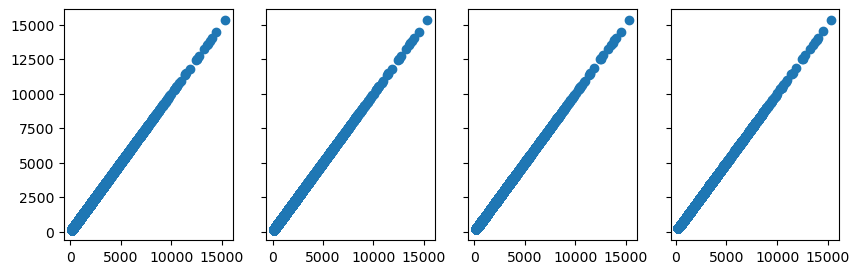

In [4]:
metric = 'duration'
fig, axs=plt.subplots(ncols=4, figsize=(10,3), sharey=True)
axs[0].scatter(all_events_df_5mins[metric], all_events_df_5mins[metric])
axs[1].scatter(all_events_df_10mins[metric], all_events_df_10mins[metric])
axs[2].scatter(all_events_df_30mins[metric], all_events_df_30mins[metric])
axs[3].scatter(all_events_df_60mins[metric], all_events_df_60mins[metric]);

### Remove rows with unrealistically high precip

In [5]:
bad_indices = all_events_df_5mins.sort_values(by="total_precip", ascending=False)[:15].index

# Drop rows at these indices from all dataframes
all_events_df_5mins = all_events_df_5mins.drop(index=bad_indices)
all_events_df_10mins = all_events_df_10mins.drop(index=bad_indices)
all_events_df_30mins = all_events_df_30mins.drop(index=bad_indices)
all_events_df_60mins = all_events_df_60mins.drop(index=bad_indices)

for df in [all_events_df_5mins, all_events_df_10mins, all_events_df_30mins, all_events_df_60mins]:
    df.reset_index(drop=True, inplace=True)
    
print(len(all_events_df_5mins), len(all_events_df_10mins), len(all_events_df_30mins), len(all_events_df_60mins))

364464 364464 364464 364464


### Specify just raw columns to keep

In [6]:
raw_cols = []
for col in all_events_df_5mins.columns:
    if not col.endswith('_DMC_10') and not col.endswith('dblnorm'):
        raw_cols.append(col)

### Also remove 'frac_q1', 'frac_q2', 'frac_q3', 'frac_q4'
Because these bring lots of nans (with current calculation method)

In [7]:
cols_to_del = ['frac_q1', 'frac_q2', 'frac_q3', 'frac_q4']
more_cols_to_del = ['gauge_num',  'start_time', 'end_time', 'duration' ,'total_precip',  'event_num', 'peak_mean_ratio_scaled',
                   'heaviest_half']

raw_cols = [x for x in raw_cols if x not in cols_to_del]  
raw_cols = [x for x in raw_cols if x not in more_cols_to_del]    

### Do the actual deleting

In [8]:
all_events_df_5mins_raw = all_events_df_5mins[raw_cols]
all_events_df_10mins_raw = all_events_df_10mins[raw_cols]
all_events_df_30mins_raw = all_events_df_30mins[raw_cols]
all_events_df_60mins_raw = all_events_df_60mins[raw_cols]

In [9]:
print(len(all_events_df_5mins_raw), len(all_events_df_10mins_raw), len(all_events_df_30mins_raw), len(all_events_df_60mins_raw))

bad_indices_all = []
for all_events_df in [all_events_df_5mins_raw, all_events_df_10mins_raw, all_events_df_30mins_raw, all_events_df_60mins_raw]:
    columns_with_nan = all_events_df.columns[all_events_df.isnull().any()].tolist()
    print("Columns with at least one NaN value:")
    print(columns_with_nan)
    # #Find indices of rows with any NaNs in the 60-minute data
    bad_indices = all_events_df[all_events_df.isnull().any(axis=1)].index
    bad_indices_lst = bad_indices.tolist()
    print(len(bad_indices_lst))
    if len(bad_indices) >0:
        bad_indices_all.extend(bad_indices_lst)
    
# Drop rows at these indices from all dataframes
all_events_df_5mins_raw = all_events_df_5mins_raw.drop(index=bad_indices_all)
all_events_df_10mins_raw = all_events_df_10mins_raw.drop(index=bad_indices_all)
all_events_df_30mins_raw = all_events_df_30mins_raw.drop(index=bad_indices_all)
all_events_df_60mins_raw = all_events_df_60mins_raw.drop(index=bad_indices_all)   

print(len(all_events_df_5mins_raw), len(all_events_df_10mins_raw), len(all_events_df_30mins_raw), len(all_events_df_60mins_raw))

364464 364464 364464 364464
Columns with at least one NaN value:
[]
0
Columns with at least one NaN value:
[]
0
Columns with at least one NaN value:
[]
0
Columns with at least one NaN value:
['asymm_d', 'Event Loading', 'lorentz_asymetry', 'Mean Intensity HIZ']
6
364458 364458 364458 364458


### Join all into one dataframe

In [11]:
metric_columns =all_events_df_5mins_raw.columns

In [12]:
all_events_df_5mins_raw = all_events_df_5mins_raw.add_suffix('_5m')
all_events_df_10mins_raw = all_events_df_10mins_raw.add_suffix('_10m')
all_events_df_30mins_raw = all_events_df_30mins_raw.add_suffix('_30m')
all_events_df_60mins_raw = all_events_df_60mins_raw.add_suffix('_60m')

In [13]:
all_events_all_res = pd.concat([all_events_df_5mins_raw, all_events_df_10mins_raw,
                               all_events_df_30mins_raw, all_events_df_60mins_raw], axis=1)

## Check skewness of variables

In [ ]:
# metric_columns = all_events_df.columns
# metric_columns = metric_columns.drop(['gauge_num', "start_time", "end_time"])
# all_events_df = all_events_df[metric_columns]

## Scale variables

In [16]:
metrics_to_scale = all_events_all_res.columns
standard_scaler = MinMaxScaler()
transformed_scaled = standard_scaler.fit_transform(all_events_all_res[metrics_to_scale])
# # Convert scaled values back to DataFrame and concatenate with original non-numeric columns
transformed_scaled = pd.DataFrame(transformed_scaled, columns=metrics_to_scale)

### Taylor Plot

In [21]:
import skill_metrics as sm

In [28]:
# Assuming you already created:
# stds_5m, stds_30m, corrs, valid_metrics from your previous steps

# Set threshold to filter out low-variance reference metrics
min_std_threshold = 0.1
stds_5m = np.array(std_5m)
stds_30m = np.array(std_30m)
corrs = np.array(corrs)
valid_metrics = np.array(valid_metrics)

mask = stds_5m > min_std_threshold

ref_std = np.mean(stds_5m[mask])  # or 1.0 if normalized
filtered_stds = stds_30m[mask]
filtered_corrs = corrs[mask]
filtered_labels = valid_metrics[mask]


In [72]:
# Create Taylor diagram
sm.taylor_diagram(
    stdref=ref_std,
    std=filtered_stds,
    corrcoef=filtered_corrs,
    markerLabel=filtered_labels,
    markerSize=8,
    markerColor='r',
    colCOR='black',
    colSTD='grey',
    styleCOR='dashed',
    styleSTD='dotted',
    tickRMS=np.arange(0, np.max(filtered_stds) + 0.5, 0.5),
    colRMS='lightgrey'
)
plt.show()

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

class TaylorDiagram:
    def __init__(self, refstd, fig=None, rect=111, label='Reference'):
        self.refstd = refstd
        self.fig = fig or plt.figure()
        self.ax = self.fig.add_subplot(rect, polar=True)

        # Correlation labels
        t = np.arccos(np.linspace(0, 1, 100))
        r = np.linspace(0, 1.5 * refstd, 100)
        self.ax.set_theta_direction(-1)
        self.ax.set_theta_zero_location("E")
        self.ax.set_thetalim(0, np.pi / 2)

        self.ax.plot(np.arccos([1, 0.5, 0]), [refstd]*3, 'k+', markersize=10)

        # Add reference point
        self.ax.plot(0, refstd, 'ko', label=label)
        self.sample_points = []

    def add_sample(self, stddev, corrcoef, label='', **kwargs):
        theta = np.arccos(corrcoef)
        r = stddev
        p, = self.ax.plot(theta, r, 'o', label=label, **kwargs)
        self.sample_points.append(p)
        return p


In [42]:
metrics_to_scale = all_events_all_res.columns
minmax_scaler = MinMaxScaler()
transformed_minmax_scaled = minmax_scaler.fit_transform(all_events_all_res[metrics_to_scale])
# # Convert scaled values back to DataFrame and concatenate with original non-numeric columns
transformed_minmax_scaled = pd.DataFrame(transformed_minmax_scaled, columns=metrics_to_scale)

In [43]:
metrics_to_scale = all_events_all_res.columns
standard_scaler = StandardScaler()
transformed_standard_scaled = standard_scaler.fit_transform(all_events_all_res[metrics_to_scale])
# # Convert scaled values back to DataFrame and concatenate with original non-numeric columns
transformed_standard_scaled = pd.DataFrame(transformed_standard_scaled, columns=metrics_to_scale)

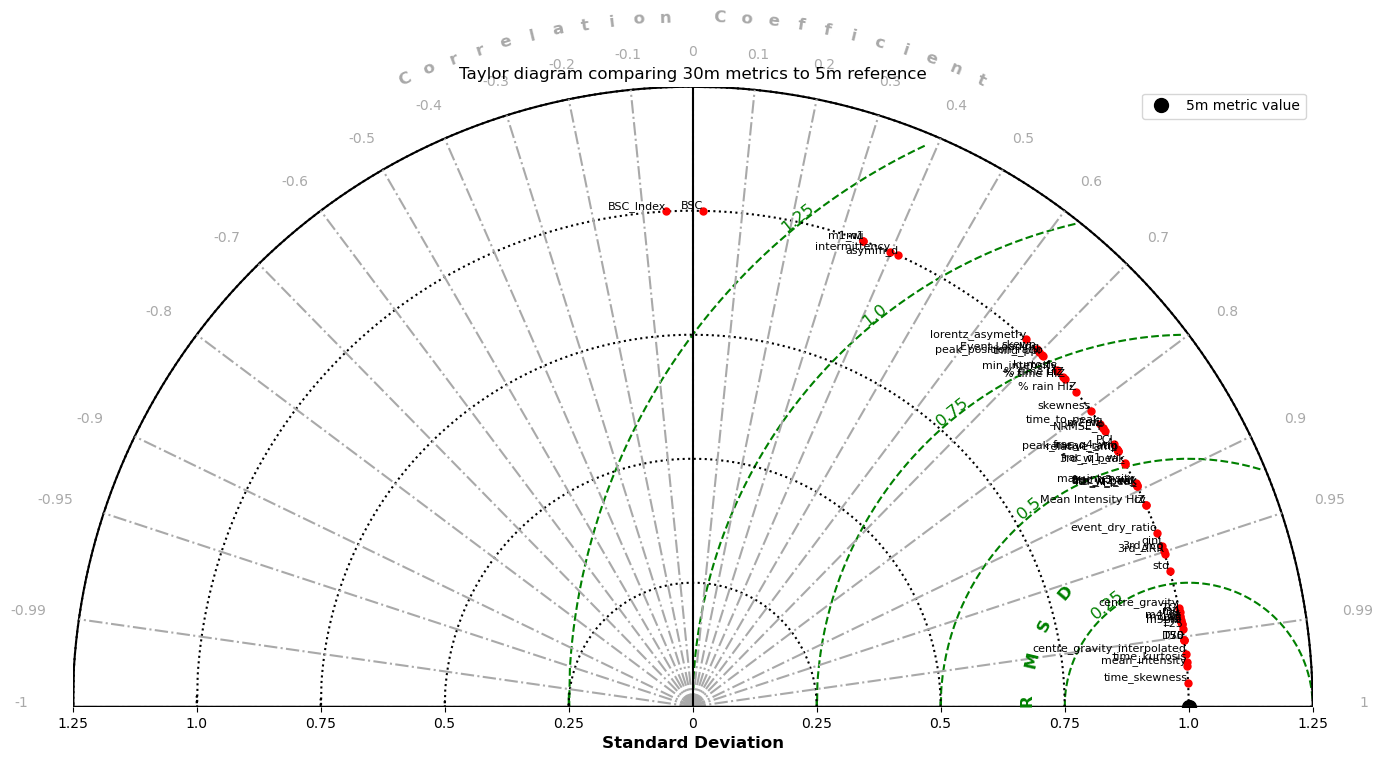

In [44]:
import skill_metrics as sm
import numpy as np
import matplotlib.pyplot as plt

# --- Helper function to split column name into metric and resolution --- #
def split_metric_resolution(col_name):
    """
    Splits column names like '3rd_w_Peak_5m' into ('3rd_w_Peak', '5m').
    Assumes resolution is always the last underscore-suffix (e.g., '_5m').
    """
    parts = col_name.rsplit('_', 1)  # Split only on the last underscore
    if len(parts) == 2 and parts[1] in ['5m', '30m']:
        return parts[0], parts[1]
    else:
        return col_name, None  # No valid resolution suffix found

# --- Identify unique metric names (e.g., 't50', '3rd_w_Peak') --- #
metrics = set()
for col in transformed_standard_scaled.columns:
    metric, res = split_metric_resolution(col)
    if res is not None:
        metrics.add(metric)
metrics = sorted(metrics)  # Sort for consistent ordering

# --- Prepare arrays to hold statistics --- #
std_ref_all = []   # Standard deviations of reference (5m) metrics
rms_ref_all = []   # RMSD of reference points (always 0)
corr_ref_all = []  # Correlation of reference points (always 1)

stds = []   # STD of 30m values
rmsds = []  # Centered RMSD between 30m and 5m
cors = []   # Pearson correlation coefficients
labels = [] # Metric names for labeling

# --- Loop through first 10 metrics and compute comparison statistics --- #
for metric in metrics:  # Limit to 10 metrics for clarity
    col_5m = f"{metric}_5m"
    col_30m = f"{metric}_30m"

    # Check both columns exist
    if col_5m in transformed_standard_scaled.columns and col_30m in transformed_standard_scaled.columns:
        ref = transformed_standard_scaled[col_5m].values
        mod = transformed_standard_scaled[col_30m].values

        # Mask to drop any NaN values
        mask = ~np.isnan(ref) & ~np.isnan(mod)
        ref = ref[mask]
        mod = mod[mask]

        if len(ref) > 1:
            # Compute stats
            std_ref = np.std(ref, ddof=1)  # standard deviation of reference
            std_mod = np.std(mod, ddof=1)  # standard deviation of model
            corr = np.corrcoef(ref, mod)[0,1]  # Pearson correlation
            rmsd_centered = np.sqrt(np.mean(((mod - np.mean(mod)) - (ref - np.mean(ref)))**2))

            # Append reference stats
            std_ref_all.append(std_ref)
            rms_ref_all.append(0)  # ref has 0 RMSD
            corr_ref_all.append(1) # ref has perfect correlation

            # Append model stats
            stds.append(std_mod)
            rmsds.append(rmsd_centered)
            cors.append(corr)
            labels.append(metric)  # label with metric name

# --- Compose input arrays in required format for skill_metrics --- #
# Reference must be first in all arrays
STDs = np.array([std_ref_all[0]] + stds)   # reference std + model stds
RMSs = np.array([0] + rmsds)               # reference RMS (0) + model RMSs
CORs = np.array([1] + cors)                # reference correlation (1) + model corrs

# --- Optional: manually plot the reference point for clarity --- #
ref_std = STDs[0]  # Reference standard deviation (used for locating the black dot)

# Create plot
plt.figure(figsize=(16,20))

# Manually add black dot for reference point at angle 0° (horizontal)
plt.plot(ref_std, 0, 'ko', label='5m metric value', markersize=10)

# --- Call Taylor diagram plotting function --- #
sm.taylor_diagram(
    STDs, 
    RMSs, 
    CORs, 
    markerLabel=['5m_ref'] + labels,  # first label is ignored (ref not plotted), rest are metric names
    colCOR='darkgray',     # make correlation contour lines lighter
        styleRMS='--',                # Dashed lines for RMSD
    colRMS='green'                 # Gray color for RMSD contours
)

# --- Final layout adjustments --- #
plt.title("Taylor diagram comparing 30m metrics to 5m reference")
plt.legend(loc='upper right')  # Add legend for reference dot
plt.show()


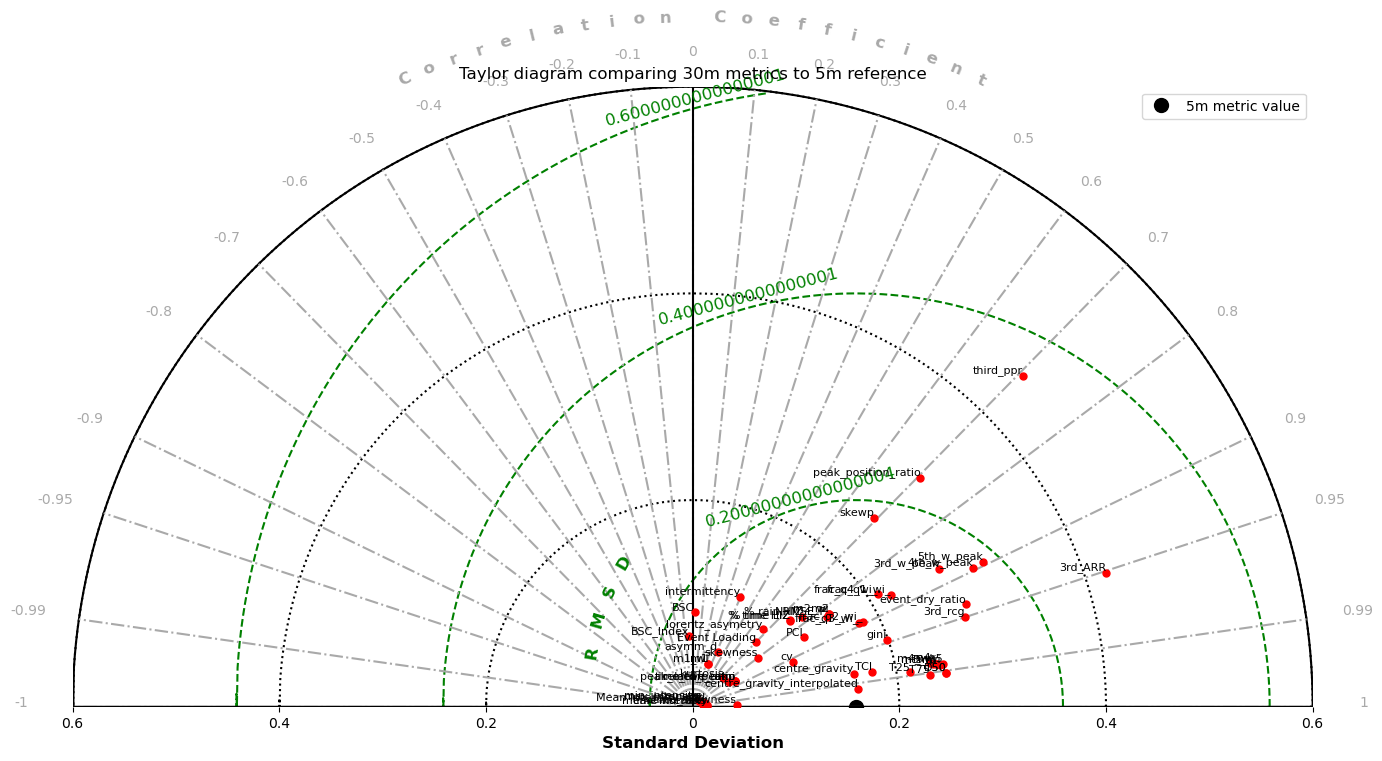

In [70]:
import skill_metrics as sm
import numpy as np
import matplotlib.pyplot as plt

# --- Helper function to split column name into metric and resolution --- #
def split_metric_resolution(col_name):
    """
    Splits column names like '3rd_w_Peak_5m' into ('3rd_w_Peak', '5m').
    Assumes resolution is always the last underscore-suffix (e.g., '_5m').
    """
    parts = col_name.rsplit('_', 1)  # Split only on the last underscore
    if len(parts) == 2 and parts[1] in ['5m', '30m']:
        return parts[0], parts[1]
    else:
        return col_name, None  # No valid resolution suffix found

# --- Identify unique metric names (e.g., 't50', '3rd_w_Peak') --- #
metrics = set()
for col in transformed_minmax_scaled.columns:
    metric, res = split_metric_resolution(col)
    if res is not None:
        metrics.add(metric)
metrics = sorted(metrics)  # Sort for consistent ordering

# --- Prepare arrays to hold statistics --- #
std_ref_all = []   # Standard deviations of reference (5m) metrics
rms_ref_all = []   # RMSD of reference points (always 0)
corr_ref_all = []  # Correlation of reference points (always 1)

stds = []   # STD of 30m values
rmsds = []  # Centered RMSD between 30m and 5m
cors = []   # Pearson correlation coefficients
labels = [] # Metric names for labeling

# --- Loop through first 10 metrics and compute comparison statistics --- #
for metric in metrics:  # Limit to 10 metrics for clarity
    col_5m = f"{metric}_5m"
    col_30m = f"{metric}_30m"

    # Check both columns exist
    if col_5m in transformed_minmax_scaled.columns and col_30m in transformed_minmax_scaled.columns:
        ref = transformed_minmax_scaled[col_5m].values
        mod = transformed_minmax_scaled[col_30m].values

        # Mask to drop any NaN values
        mask = ~np.isnan(ref) & ~np.isnan(mod)
        ref = ref[mask]
        mod = mod[mask]

        if len(ref) > 1:
            # Compute stats
            std_ref = np.std(ref, ddof=1)  # standard deviation of reference
            std_mod = np.std(mod, ddof=1)  # standard deviation of model
            corr = np.corrcoef(ref, mod)[0,1]  # Pearson correlation
            rmsd_centered = np.sqrt(np.mean(((mod - np.mean(mod)) - (ref - np.mean(ref)))**2))

            # Append reference stats
            std_ref_all.append(std_ref)
            rms_ref_all.append(0)  # ref has 0 RMSD
            corr_ref_all.append(1) # ref has perfect correlation

            # Append model stats
            stds.append(std_mod)
            rmsds.append(rmsd_centered)
            cors.append(corr)
            labels.append(metric)  # label with metric name

# --- Compose input arrays in required format for skill_metrics --- #
# Reference must be first in all arrays
STDs = np.array([std_ref_all[0]] + stds)   # reference std + model stds
RMSs = np.array([0] + rmsds)               # reference RMS (0) + model RMSs
CORs = np.array([1] + cors)                # reference correlation (1) + model corrs

# --- Optional: manually plot the reference point for clarity --- #
ref_std = STDs[0]  # Reference standard deviation (used for locating the black dot)

# Create plot
plt.figure(figsize=(16,20))

# Manually add black dot for reference point at angle 0° (horizontal)
plt.plot(ref_std, 0, 'ko', label='5m metric value', markersize=10)

# --- Call Taylor diagram plotting function --- #
sm.taylor_diagram(
    STDs, 
    RMSs, 
    CORs, 
    markerLabel=['5m_ref'] + labels,  # first label is ignored (ref not plotted), rest are metric names
    colOBS = 'r', 
    colCOR='darkgray',     # make correlation contour lines lighter
    styleRMS='--',                # Dashed lines for RMSD
    colRMS='green'     ,            # Gray color for RMSD contours
     # formatRMS='%.2f'
)

# --- Final layout adjustments --- #
plt.title("Taylor diagram comparing 30m metrics to 5m reference")
plt.legend(loc='upper right')  # Add legend for reference dot
plt.show()


In [246]:
def plot_custom_taylor_diffscales(ax, ref, mods, metric, max_std_overall,
                       mod_labels=None, ref_label='Reference',
                       mod_colors=None, ref_color='k', point_size=8):
    import numpy as np
    from matplotlib.patches import Circle

    # Show only left and bottom spines
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')

    # Clean input labels and colors
    n_mods = len(mods)
    if mod_labels is None:
        mod_labels = [f'Model {i+1}' for i in range(n_mods)]
    if mod_colors is None:
        tab10 = plt.get_cmap('tab10')
        mod_colors = [tab10(i) for i in range(n_mods)]

    # Remove NaNs in ref once
    mask = ~np.isnan(ref)
    ref = ref[mask]

    std_ref = np.std(ref, ddof=1)
    ax.plot(std_ref, 0, 'o', color=ref_color, label=ref_label, markersize=point_size)

    # Track max std/rmsd for scaling
    all_std_mods = []

    # Plot model points
    for i, mod in enumerate(mods):
        mod = np.asarray(mod)
        mask = ~np.isnan(mod) & ~np.isnan(ref)
        r = ref[mask]
        m = mod[mask]
        if len(r) < 2:
            continue
        std_mod = np.std(m, ddof=1)
        corr = np.corrcoef(r, m)[0, 1]
        rmsd_centered = np.sqrt(np.mean(((m - np.mean(m)) - (r - np.mean(r)))**2))
        theta = np.arccos(corr)

        x = std_mod * np.cos(theta)
        y = std_mod * np.sin(theta)

        ax.plot(x, y, 'o', color=mod_colors[i], label=mod_labels[i], markersize=point_size)
        all_std_mods.append(std_mod)

    # === RMSD circles centered at (std_ref, 0) ===
    max_rmsd = max([np.sqrt(np.mean(((np.asarray(mod)[~np.isnan(mod)] - np.mean(mod[~np.isnan(mod)])) - 
                                     (ref[~np.isnan(mod)] - np.mean(ref[~np.isnan(mod)])))**2))
                    for mod in mods if len(ref[~np.isnan(mod)]) > 1], default=0)

    rmsd_vals = []
    for mod in mods:
        mask = ~np.isnan(mod) & ~np.isnan(ref)
        r = ref[mask]
        m = mod[mask]
        if len(r) < 2:
            continue
        rmsd = np.sqrt(np.mean(((m - np.mean(m)) - (r - np.mean(r)))**2))
        rmsd_vals.append(rmsd)
    
    # Now set levels based on maximum RMSD
    if rmsd_vals:
        max_rmsd = max(rmsd_vals)
        rmsd_levels = np.linspace(0, max_rmsd * 1.2, 4)[1:]
        for level in rmsd_levels:
            circle = plt.Circle((std_ref, 0), level, edgecolor='green', facecolor='none',
                                linestyle='--', linewidth=1.0, alpha=0.5, zorder=1)
            ax.add_patch(circle)
            ax.text(std_ref + level, 0.02, f'{level:.2f}', fontsize=7, color='green', zorder=2)

    
    for level in rmsd_levels:
        if std_ref + level <= max_std_overall * 1.05:  # ensure it stays inside bounds
            circle = Circle((std_ref, 0), level, edgecolor='green', facecolor='none',
                            linestyle='--', linewidth=1.0, alpha=0.6)
            ax.add_patch(circle)
            ax.text(std_ref + level, 0.02, f'{level:.2f}', fontsize=6, color='green')

    # === Correlation lines ===
    corr_lines = np.linspace(0.2, 0.9, 4)
    for c in corr_lines:
        t = np.arccos(c)
        x_end = max_std_overall * np.cos(t)
        y_end = max_std_overall * np.sin(t)
        ax.plot([0, x_end], [0, y_end], color='lightgray', linestyle='--', linewidth=0.8)
        ax.text(x_end, y_end, f'{c:.1f}', fontsize=6, color='gray')

    # === Outer circular boundary ===
    outer_circle = Circle((0, 0), max_std_overall, edgecolor='black', facecolor='none', linewidth=1.2)
    ax.add_patch(outer_circle)

    # === Axes limits and appearance ===
    ax.set_xlim(0, max_std_overall * 1.1)
    ax.set_ylim(0, max_std_overall * 1.1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    # Axis labels
    ax.text(max_std_overall * 0.55, -0.05 * max_std_overall, 'Standard Deviation', ha='center', fontsize=6)
    ax.text(0.05 * max_std_overall, max_std_overall * 0.5, 'Correlation Coefficient', rotation=90, fontsize=6)

    ax.set_title(metric, fontsize=8)

    return ax


In [259]:
def plot_custom_taylor_samescale(ax, ref, mods, metric,
                       mod_labels=None, ref_label='Reference',
                       mod_colors=None, ref_color='k', point_size=8):
    import numpy as np
    from matplotlib.patches import Circle

    # Show only left and bottom spines
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')

    # Clean input labels and colors
    n_mods = len(mods)
    if mod_labels is None:
        mod_labels = [f'Model {i+1}' for i in range(n_mods)]
    if mod_colors is None:
        tab10 = plt.get_cmap('tab10')
        mod_colors = [tab10(i) for i in range(n_mods)]

    # Clean reference
    ref = np.asarray(ref)
    ref = ref[~np.isnan(ref)]
    std_ref = np.std(ref, ddof=1)

    ax.plot(std_ref, 0, 'o', color=ref_color, label=ref_label, markersize=point_size)

    std_mods = []
    model_coords = []

    for i, mod in enumerate(mods):
        mod = np.asarray(mod)
        mask = ~np.isnan(mod) & ~np.isnan(ref)
        r = ref[mask]
        m = mod[mask]
        if len(r) < 2:
            continue

        std_mod = np.std(m, ddof=1)
        corr = np.corrcoef(r, m)[0, 1]
        rmsd_centered = np.sqrt(np.mean(((m - np.mean(m)) - (r - np.mean(r)))**2))

        theta = np.arccos(corr)
        x = std_mod * np.cos(theta)
        y = std_mod * np.sin(theta)

        ax.plot(x, y, 'o', color=mod_colors[i], label=mod_labels[i], markersize=point_size)
        std_mods.append(std_mod)
        model_coords.append((x, y))

    # Dynamic axis scale
    all_stds = std_mods + [std_ref]
    max_std = max(all_stds) * 1.15

    # RMSD circles centered at (std_ref, 0)
    # Compute RMSD values relative to reference (centered)
    rmsd_vals = []
    for mod in mods:
        mask = ~np.isnan(mod) & ~np.isnan(ref)
        r = ref[mask]
        m = mod[mask]
        if len(r) < 2:
            continue
        rmsd = np.sqrt(np.mean(((m - np.mean(m)) - (r - np.mean(r)))**2))
        rmsd_vals.append(rmsd)
    
    # Now set levels based on maximum RMSD
    if rmsd_vals:
        max_rmsd = max(rmsd_vals)
        rmsd_levels = np.linspace(0, max_rmsd * 1.2, 4)[1:]
        for level in rmsd_levels:
            circle = plt.Circle((std_ref, 0), level, edgecolor='green', facecolor='none',
                                linestyle='--', linewidth=1.0, alpha=0.5, zorder=1)
            ax.add_patch(circle)
            #ax.text(std_ref + level, 0.02, f'{level:.2f}', fontsize=7, color='green', zorder=2)
            label_angle = np.pi / 8  # angle in radians (~22.5 degrees)
            label_x = std_ref + (level + 0.01) * np.cos(label_angle)
            label_y = (level + 0.01) * np.sin(label_angle)
            ax.text(label_x, label_y, f'{level:.2f}', fontsize=6, color='green', zorder=2, ha='left', va='bottom')

            
    # for level in rmsd_levels:
    #     if std_ref + level <= max_std:
    #         circle = Circle((std_ref, 0), level, edgecolor='green', facecolor='none',
    #                         linestyle='--', linewidth=1.0, alpha=0.6)
    #         ax.add_patch(circle)
    #         ax.text(std_ref + level, 0.02 * max_std, f'{level:.2f}', fontsize=6, color='green')

    # Correlation lines
    corr_lines = np.linspace(0.2, 0.9, 4)
    for c in corr_lines:
        t = np.arccos(c)
        x_end = max_std * np.cos(t)
        y_end = max_std * np.sin(t)
        ax.plot([0, x_end], [0, y_end], color='lightgray', linestyle='--', linewidth=0.8)
        ax.text(x_end, y_end, f'{c:.1f}', fontsize=6, color='gray')

    # Outer black circle
    outer_circle = Circle((0, 0), max_std, edgecolor='black', facecolor='none', linewidth=1.2)
    ax.add_patch(outer_circle)

    # Labels and formatting
    ax.set_xlim(0, max_std)
    ax.set_ylim(0, max_std)
    ax.set_aspect('equal')
    #ax.set_xticks([])
    #ax.set_yticks([])

    ax.text(max_std * 0.55, -0.05 * max_std, 'Standard Deviation', ha='center', fontsize=6)
    ax.text(0.05 * max_std, max_std * 0.5, 'Correlation Coefficient', rotation=90, fontsize=6)
    ax.set_title(metric, fontsize=8)

    return ax


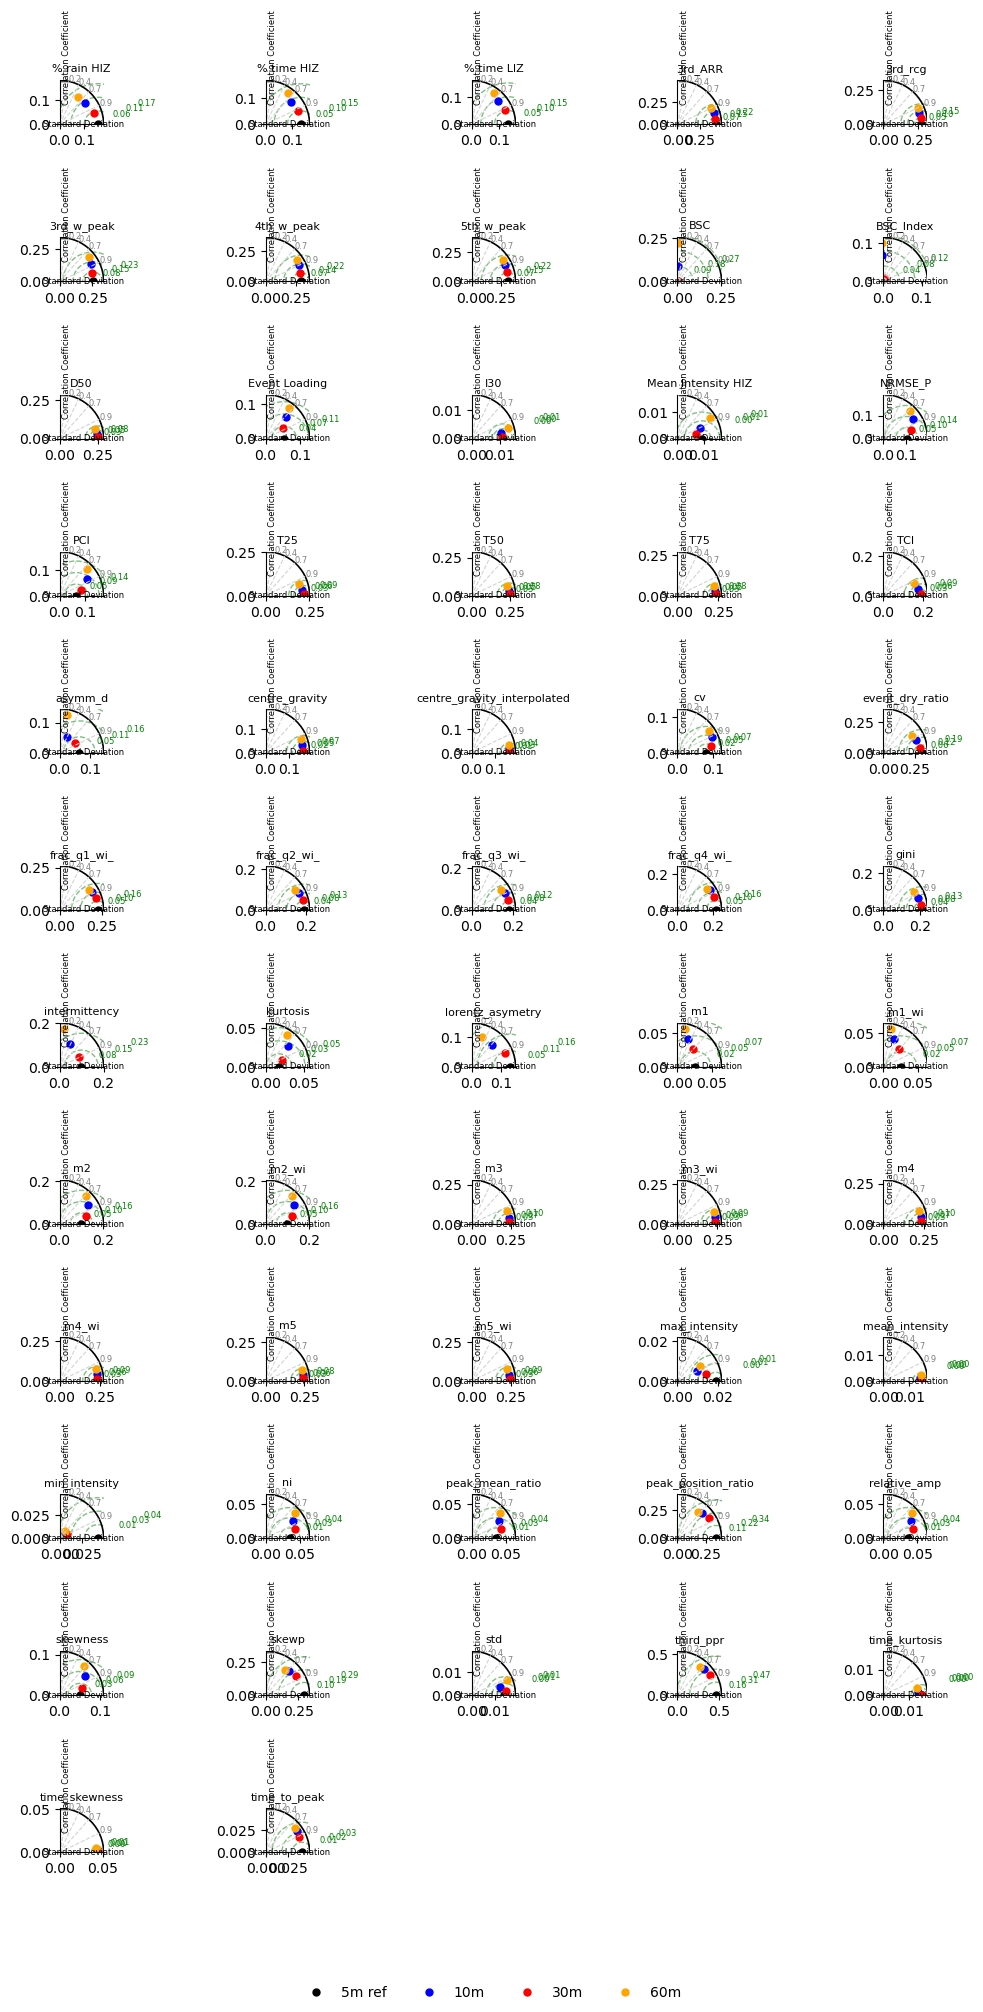

In [258]:
metrics = set()
for col in transformed_minmax_scaled.columns:
    metric, res = split_metric_resolution(col)
    if res is not None:
        metrics.add(metric)
metrics = sorted(metrics)  # Sort for consistent ordering

max_std_overall = 0
for metric in metrics:
    ref = transformed_minmax_scaled[f"{metric}_5m"].dropna().values
    for res in ['10m', '30m', '60m']:
        mod_col = f"{metric}_{res}"
        if mod_col in transformed_minmax_scaled.columns:
            mod = transformed_minmax_scaled[mod_col].dropna().values
            mask = ~np.isnan(ref) & ~np.isnan(mod)
            std_mod = np.std(mod[mask], ddof=1)
            std_ref = np.std(ref[mask], ddof=1)
            max_std_overall = max(max_std_overall, std_ref, std_mod)

fig, axes = plt.subplots(12, 5, figsize=(10,20))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ref = transformed_minmax_scaled[f'{metric}_5m'].values
    mods = [
        transformed_minmax_scaled[f'{metric}_30m'].values,
        transformed_minmax_scaled[f'{metric}_10m'].values,
        transformed_minmax_scaled[f'{metric}_60m'].values,
    ]
    mod_labels = [ '10m', '30m', '60m']
    mod_colors = [ 'blue', 'red','orange']

    plot_custom_taylor_samescale(axes[i], ref, mods, metric, 
                       mod_labels=mod_labels, mod_colors=mod_colors, 
                       ref_label='5m ref', ref_color='black', point_size = 5)

handles, labels = axes[0].get_legend_handles_labels()

for j in range(len(metrics), len(axes)):
    axes[j].axis('off')

fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=10, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at bottom for legend
plt.show()

In [263]:
def plot_custom_taylor_dynamicscale(ax, ref, mods, metric,
                                    mod_labels=None, ref_label='Reference',
                                    mod_colors=None, ref_color='k', point_size=8):
    import numpy as np
    from matplotlib.patches import Circle

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')

    n_mods = len(mods)
    if mod_labels is None:
        mod_labels = [f'Model {i+1}' for i in range(n_mods)]
    if mod_colors is None:
        tab10 = plt.get_cmap('tab10')
        mod_colors = [tab10(i) for i in range(n_mods)]

    ref = np.asarray(ref)
    ref = ref[~np.isnan(ref)]
    std_ref = np.std(ref, ddof=1)

    ax.plot(std_ref, 0, 'o', color=ref_color, label=ref_label, markersize=point_size)

    model_coords = []
    rmsd_vals = []
    std_mods = []

    for i, mod in enumerate(mods):
        mod = np.asarray(mod)
        mask = ~np.isnan(mod) & ~np.isnan(ref)
        r = ref[mask]
        m = mod[mask]
        if len(r) < 2:
            continue

        std_mod = np.std(m, ddof=1)
        corr = np.corrcoef(r, m)[0, 1]
        rmsd = np.sqrt(np.mean(((m - np.mean(m)) - (r - np.mean(r)))**2))

        theta = np.arccos(corr)
        x = std_mod * np.cos(theta)
        y = std_mod * np.sin(theta)

        ax.plot(x, y, 'o', color=mod_colors[i], label=mod_labels[i], markersize=point_size)
        model_coords.append((x, y))
        std_mods.append(std_mod)
        rmsd_vals.append(rmsd)

    max_std = max(std_mods + [std_ref]) * 1.15
    max_rmsd = max(rmsd_vals) * 1.2

    for level in np.linspace(0, max_rmsd, 4)[1:]:
        circle = Circle((std_ref, 0), level, edgecolor='green', facecolor='none',
                        linestyle='--', linewidth=1.0, alpha=0.5)
        ax.add_patch(circle)
        label_angle = np.pi / 8
        label_x = std_ref + (level + 0.01) * np.cos(label_angle)
        label_y = (level + 0.01) * np.sin(label_angle)
        ax.text(label_x, label_y, f'{level:.2f}', fontsize=6, color='green', ha='left', va='bottom')

    corr_lines = np.linspace(0.2, 0.9, 4)
    for c in corr_lines:
        t = np.arccos(c)
        x_end = max_std * np.cos(t)
        y_end = max_std * np.sin(t)
        ax.plot([0, x_end], [0, y_end], color='lightgray', linestyle='--', linewidth=0.8)
        ax.text(x_end, y_end, f'{c:.1f}', fontsize=6, color='gray')

    ax.add_patch(Circle((0, 0), max_std, edgecolor='black', facecolor='none', linewidth=1.2))

    ax.set_xlim(0, max_std)
    ax.set_ylim(0, max_std)
    ax.set_aspect('equal')
    ax.text(max_std * 0.55, -0.05 * max_std, 'Standard Deviation', ha='center', fontsize=6)
    ax.text(0.05 * max_std, max_std * 0.5, 'Correlation Coefficient', rotation=90, fontsize=6)
    ax.set_title(metric, fontsize=8)

    return ax

def plot_custom_taylor_fixedscale(ax, ref, mods, metric,
                                  mod_labels=None, ref_label='Reference',
                                  mod_colors=None, ref_color='k', point_size=8,
                                  fixed_max_std=None, fixed_max_rmsd=None):
    import numpy as np
    from matplotlib.patches import Circle

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')

    n_mods = len(mods)
    if mod_labels is None:
        mod_labels = [f'Model {i+1}' for i in range(n_mods)]
    if mod_colors is None:
        tab10 = plt.get_cmap('tab10')
        mod_colors = [tab10(i) for i in range(n_mods)]

    ref = np.asarray(ref)
    ref = ref[~np.isnan(ref)]
    std_ref = np.std(ref, ddof=1)

    ax.plot(std_ref, 0, 'o', color=ref_color, label=ref_label, markersize=point_size)

    model_coords = []
    rmsd_vals = []
    std_mods = []

    for i, mod in enumerate(mods):
        mod = np.asarray(mod)
        mask = ~np.isnan(mod) & ~np.isnan(ref)
        r = ref[mask]
        m = mod[mask]
        if len(r) < 2:
            continue

        std_mod = np.std(m, ddof=1)
        corr = np.corrcoef(r, m)[0, 1]
        rmsd = np.sqrt(np.mean(((m - np.mean(m)) - (r - np.mean(r)))**2))

        theta = np.arccos(corr)
        x = std_mod * np.cos(theta)
        y = std_mod * np.sin(theta)

        ax.plot(x, y, 'o', color=mod_colors[i], label=mod_labels[i], markersize=point_size)
        model_coords.append((x, y))
        std_mods.append(std_mod)
        rmsd_vals.append(rmsd)

    max_std = fixed_max_std if fixed_max_std is not None else max(std_mods + [std_ref]) * 1.15
    max_rmsd = fixed_max_rmsd if fixed_max_rmsd is not None else max(rmsd_vals) * 1.2

    for level in np.linspace(0, max_rmsd, 4)[1:]:
        circle = Circle((std_ref, 0), level, edgecolor='green', facecolor='none',
                        linestyle='--', linewidth=1.0, alpha=0.5)
        ax.add_patch(circle)
        label_angle = np.pi / 8
        label_x = std_ref + (level + 0.01) * np.cos(label_angle)
        label_y = (level + 0.01) * np.sin(label_angle)
        ax.text(label_x, label_y, f'{level:.2f}', fontsize=6, color='green', ha='left', va='bottom')

    corr_lines = np.linspace(0.2, 0.9, 4)
    for c in corr_lines:
        t = np.arccos(c)
        x_end = max_std * np.cos(t)
        y_end = max_std * np.sin(t)
        ax.plot([0, x_end], [0, y_end], color='lightgray', linestyle='--', linewidth=0.8)
        ax.text(x_end, y_end, f'{c:.1f}', fontsize=6, color='gray')

    ax.add_patch(Circle((0, 0), max_std, edgecolor='black', facecolor='none', linewidth=1.2))

    ax.set_xlim(0, max_std)
    ax.set_ylim(0, max_std)
    ax.set_aspect('equal')
    ax.text(max_std * 0.55, -0.05 * max_std, 'Standard Deviation', ha='center', fontsize=6)
    ax.text(0.05 * max_std, max_std * 0.5, 'Correlation Coefficient', rotation=90, fontsize=6)
    ax.set_title(metric, fontsize=8)

    return ax


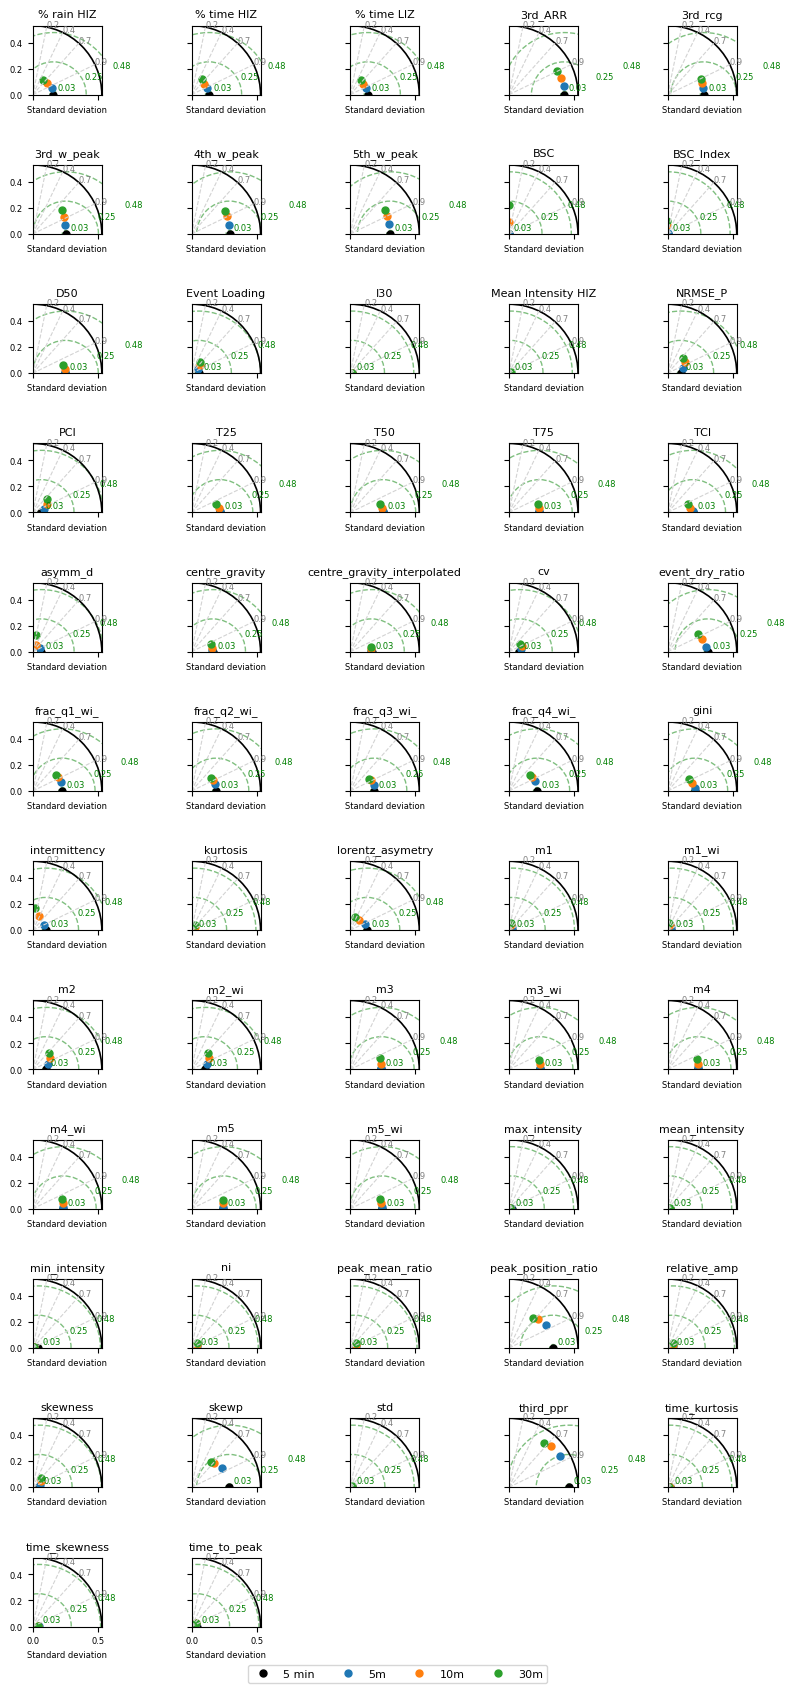

In [310]:
def plot_fixedscale_taylor(data_df, metrics, resolutions, ax_list,
                            mod_labels=None, ref_label='5 min',
                            mod_colors=None, ref_color='k', point_size=8):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    # Prepare consistent axis limits
    std_refs = []
    std_mods = []

    # First pass: gather stds for fixed limits
    for metric in metrics:
        ref = data_df[f'{metric}_5m'].dropna()
        std_refs.append(np.std(ref, ddof=1))
        for res in resolutions:
            if res == '5m': continue
            mod = data_df[f'{metric}_{res}'].dropna()
            common = ref.index.intersection(mod.index)
            std_mods.append(np.std(mod.loc[common], ddof=1))
    max_std = max(std_refs + std_mods) * 1.15  # Global fixed scale

    # Second pass: plot
    for ax, metric in zip(ax_list, metrics):
        ref = data_df[f'{metric}_5m'].dropna()
        std_ref = np.std(ref, ddof=1)
        ax.plot(std_ref, 0, 'o', color=ref_color, label=ref_label, markersize=point_size)

        if mod_labels is None:
            mod_labels = resolutions[1:]
        if mod_colors is None:
            tab10 = plt.get_cmap('tab10')
            mod_colors = [tab10(i) for i in range(len(mod_labels))]

        for i, res in enumerate(resolutions):
            if res == '5m': continue
            mod = data_df[f'{metric}_{res}'].dropna()
            common = ref.index.intersection(mod.index)
            r, m = ref.loc[common], mod.loc[common]
            if len(r) < 2:
                continue
            std_mod = np.std(m, ddof=1)
            corr = np.corrcoef(r, m)[0, 1]
            theta = np.arccos(corr)
            x = std_mod * np.cos(theta)
            y = std_mod * np.sin(theta)
            ax.plot(x, y, 'o', color=mod_colors[i - 1], label=mod_labels[i - 1], markersize=point_size)

        # RMSD circles
        for level in np.linspace(0.05 * max_std, max_std * 0.9, 3):
            ax.add_patch(Circle((std_ref, 0), level, edgecolor='green', facecolor='none',
                                linestyle='--', linewidth=1.0, alpha=0.5))
            label_angle = np.pi / 8
            ax.text(std_ref + (level + 0.01) * np.cos(label_angle),
                    (level + 0.01) * np.sin(label_angle),
                    f'{level:.2f}', fontsize=6, color='green', ha='left', va='bottom')

        # Correlation lines
        for c in np.linspace(0.2, 0.9, 4):
            t = np.arccos(c)
            x_end, y_end = max_std * np.cos(t), max_std * np.sin(t)
            ax.plot([0, x_end], [0, y_end], color='lightgray', linestyle='--', linewidth=0.8)
            ax.text(x_end, y_end, f'{c:.1f}', fontsize=6, color='gray')

        # Final setup
        ax.add_patch(Circle((0, 0), max_std, edgecolor='black', facecolor='none', linewidth=1.2))
        ax.set_xlim(0, max_std)
        ax.set_ylim(0, max_std)
        ax.set_aspect('equal')
        # ax.text(max_std * 0.55, -0.05 * max_std, 'Standard Deviation', ha='center', fontsize=6)
        # ax.text(0.05 * max_std, max_std * 0.5, 'Correlation Coefficient', rotation=90, fontsize=6)
        ax.set_title(metric, fontsize=8)
        ax.set_xlabel("Standard deviation", fontsize=6)
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.tick_params(axis='both', which='minor', labelsize=6)

metrics = set()
for col in transformed_minmax_scaled.columns:
    metric, res = split_metric_resolution(col)
    if res is not None:
        metrics.add(metric)
metrics = sorted(metrics)  # Sort for consistent ordering

resolutions = ['5m', '10m', '30m', '60m']
mod_labels = ['5m', '10m', '30m']


# Create 8x8 subplot grid
fig, axs = plt.subplots(12, 5, figsize=(8, 17), sharex=True, sharey=True)
axs = axs.flatten()

# Call the fixed-scale plot function (the one you already have)
plot_fixedscale_taylor(transformed_minmax_scaled, metrics, resolutions, axs, mod_labels=mod_labels, point_size = 5)

# Hide unused axes (if metrics < 64)
for ax in axs[len(metrics):]:
    ax.axis('off')

# Optional: shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(mod_labels)+1, fontsize=8)

plt.tight_layout()
plt.show()


Index(['I30_5m', 'time_to_peak_5m', 'peak_position_ratio_5m', 'std_5m',
       'max_intensity_5m', 'mean_intensity_5m', 'min_intensity_5m', 'cv_5m',
       'skewness_5m', 'kurtosis_5m',
       ...
       '5th_w_peak_60m', 'third_ppr_60m', '3rd_ARR_60m', '3rd_rcg_60m',
       'T25_60m', 'T50_60m', 'T75_60m', 'D50_60m', 'BSC_60m', 'BSC_Index_60m'],
      dtype='object', length=228)

In [316]:
for metric in metrics:
    ref = transformed_minmax_scaled[f'{metric}_5m'].dropna()
    print(metric, np.std(ref))
    for res in resolutions:
        if res == '5m': continue
        mod = transformed_minmax_scaled[f'{metric}_{res}'].dropna()
        common = ref.index.intersection(mod.index)

% rain HIZ 0.1583852579484079
% time HIZ 0.1329866686958457
% time LIZ 0.13304215374280762
3rd_ARR 0.42413263214191116
3rd_rcg 0.27627365055945613
3rd_w_peak 0.25236445712520095
4th_w_peak 0.2915112416513127
5th_w_peak 0.3069448825355447
BSC 0.0016583424658790466
BSC_Index 0.002342522690401456
D50 0.25094228166416044
Event Loading 0.05409669587005699
I30 0.01094038260656145
Mean Intensity HIZ 0.00931963034540842
NRMSE_P 0.10079453644636754
PCI 0.06447593437710546
T25 0.21888086794750214
T50 0.25094228166416044
T75 0.2336505076243621
TCI 0.19230696609420397
asymm_d 0.06533359180462946
centre_gravity 0.16256539476938991
centre_gravity_interpolated 0.1630286098758766
cv 0.08021283253317499
event_dry_ratio 0.3078843085478201
frac_q1_wi_ 0.22645273605122726
frac_q2_wi_ 0.18801336015281359
frac_q3_wi_ 0.18256274375832582
frac_q4_wi_ 0.21417240314493405
gini 0.20873896919216897
intermittency 0.09936912368038983
kurtosis 0.017489007549096384
lorentz_asymetry 0.1285443027447981
m1 0.02614247679

0.29075479562907897


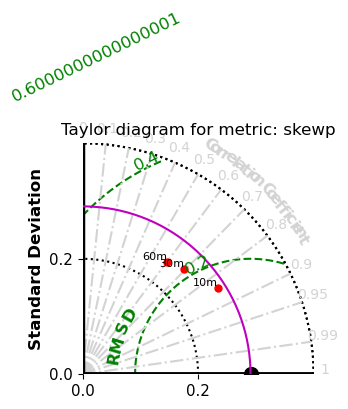

In [311]:
# === Settings ===
metric = 'skewp'  # Replace with your metric name
col_5m = f'{metric}_5m'
col_10m = f'{metric}_10m'
col_30m = f'{metric}_30m'
col_60m = f'{metric}_60m'

# === Extract data ===
ref = transformed_minmax_scaled[col_5m].values
mod_10 = transformed_minmax_scaled[col_10m].values
mod_30 = transformed_minmax_scaled[col_30m].values
mod_60 = transformed_minmax_scaled[col_60m].values

# Remove missing values
mask = ~np.isnan(ref) & ~np.isnan(mod)
ref = ref[mask]
mod_10 = mod_10[mask]
mod_30 = mod_30[mask]
mod_60 = mod_60[mask]

# === Calculate statistics ===
std_ref = np.std(ref, ddof=1)
print(std_ref)
std_mod_10 = np.std(mod_10, ddof=1)
std_mod_30 = np.std(mod_30, ddof=1)
std_mod_60 = np.std(mod_60, ddof=1)

corr_10 = np.corrcoef(ref, mod_10)[0, 1]
corr_30 = np.corrcoef(ref, mod_30)[0, 1]
corr_60 = np.corrcoef(ref, mod_60)[0, 1]

rmsd_centered_10 = np.sqrt(np.mean(((mod_10 - np.mean(mod_10)) - (ref - np.mean(ref)))**2))
rmsd_centered_30 = np.sqrt(np.mean(((mod_30 - np.mean(mod_30)) - (ref - np.mean(ref)))**2))
rmsd_centered_60 = np.sqrt(np.mean(((mod_60 - np.mean(mod_60)) - (ref - np.mean(ref)))**2))

# === Convert to NumPy arrays ===
STDs = np.array([std_ref, std_mod_10, std_mod_30, std_mod_60])
RMSs = np.array([0, rmsd_centered_10, rmsd_centered_30, rmsd_centered_60])
CORs = np.array([1, corr_10, corr_30, corr_60])

# === Plot ===
plt.figure(figsize=(3, 3))
plt.plot(std_ref, 0, 'ko', label='Reference', markersize=10)  # Reference point
sm.taylor_diagram(
    STDs, RMSs, CORs,
    markerLabel=['5m_ref', '10m', '30m', '60m'],
    colCOR='lightgray',
    colRMS='green',
    markerSize=10,
    styleOBS='-',
)
plt.title(f"Taylor diagram for metric: {metric}")
plt.show()


### Cohen's D and Instability

In [18]:
categorical_metric_list = []

for metric in metric_columns:
    unique_vals = all_events_df[metric].dropna().unique()
    if len(unique_vals) < 6:
        categorical_metric_list.append(metric)

print("Detected categorical metrics:", categorical_metric_list)

Detected categorical metrics: ['3rd_w_peak', '4th_w_peak', '5th_w_peak', 'third_ppr', '3rd_ARR', '3rd_rcg']


In [55]:
# print("Metric & Cohen's d\\_10m & Instability\\_10m & Cohen's d\\_30m & Instability\\_30m & Cohen's d\\_60m & Instability\\_60m \\\\")

# for metric in metric_columns:
#     row = [metric]
#     for res in ['10m', '30m', '60m']:
#         metric_fine = transformed_scaled[f"{metric}_5m"]
#         metric_coarse = transformed_scaled[f"{metric}_{res}"]
#         d, meaning = cohens_d(metric_fine, metric_coarse)
#         instab, translation = instability_index(metric_fine, metric_coarse)
        
#         if metric in categorical_metric_list:
#             instab_rank, meaning_rank = ordinal_ranking_instability(metric_fine, metric_coarse)
#             delta, meaning_num = cliffs_delta_fast(metric_fine, metric_coarse)
#             row.append(f"{meaning_rank} ({instab_rank:.2f})")
#             row.append(f"{meaning_num} ({delta:.2f})")
#         else:
#             d, meaning = cohens_d(metric_fine, metric_coarse)
#             instab, translation = instability_index(metric_fine, metric_coarse)
#             row.append(f"{meaning} ({d:.2f})")
#             row.append(f"{translation} ({instab:.2f})")
#     print(" & ".join(row) + " \\\\")


In [24]:
print("Metric & Cohen's d\\_10m & Instability\\_10m & Cohen's d\\_30m & Instability\\_30m & Cohen's d\\_60m & Instability\\_60m \\\\")

for metric in metric_columns:
    row = [metric]
    for res in ['10m', '30m', '60m']:
        metric_fine = transformed_scaled[f"{metric}_5m"]
        metric_coarse = transformed_scaled[f"{metric}_{res}"]
        d, meaning = cohens_d(metric_fine, metric_coarse)
        instab, translation = instability_index(metric_fine, metric_coarse)
        row.append(f"{meaning} ({d:.2f})")
        row.append(f"{translation} ({instab:.2f})")
    print(" & ".join(row) + " \\\\")


Metric & Cohen's d\_10m & Instability\_10m & Cohen's d\_30m & Instability\_30m & Cohen's d\_60m & Instability\_60m \\
3rd_w_peak & Very low (0.03) & Negligible (0.01) \\
3rd_w_peak & Low (0.11) & Negligible (0.03) \\
3rd_w_peak & Moderate (0.21) & Negligible (0.08) \\
4th_w_peak & Very low (0.03) & Negligible (0.01) \\
4th_w_peak & Low (0.12) & Negligible (0.03) \\
4th_w_peak & Moderate (0.20) & Negligible (0.09) \\
5th_w_peak & Very low (0.04) & Negligible (0.01) \\
5th_w_peak & Low (0.13) & Negligible (0.04) \\
5th_w_peak & Moderate (0.22) & Negligible (0.11) \\
third_ppr & Moderate (0.17) & Negligible (0.00) \\
third_ppr & Moderate (0.32) & Negligible (0.04) \\
third_ppr & High (0.41) & Negligible (0.08) \\
3rd_ARR & Very low (0.02) & Negligible (0.01) \\
3rd_ARR & Low (0.07) & Negligible (0.05) \\
3rd_ARR & Low (0.13) & Negligible (0.10) \\
3rd_rcg & Very low (0.02) & Negligible (0.00) \\
3rd_rcg & Low (0.06) & Negligible (0.00) \\
3rd_rcg & Low (0.11) & Negligible (0.00) \\


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


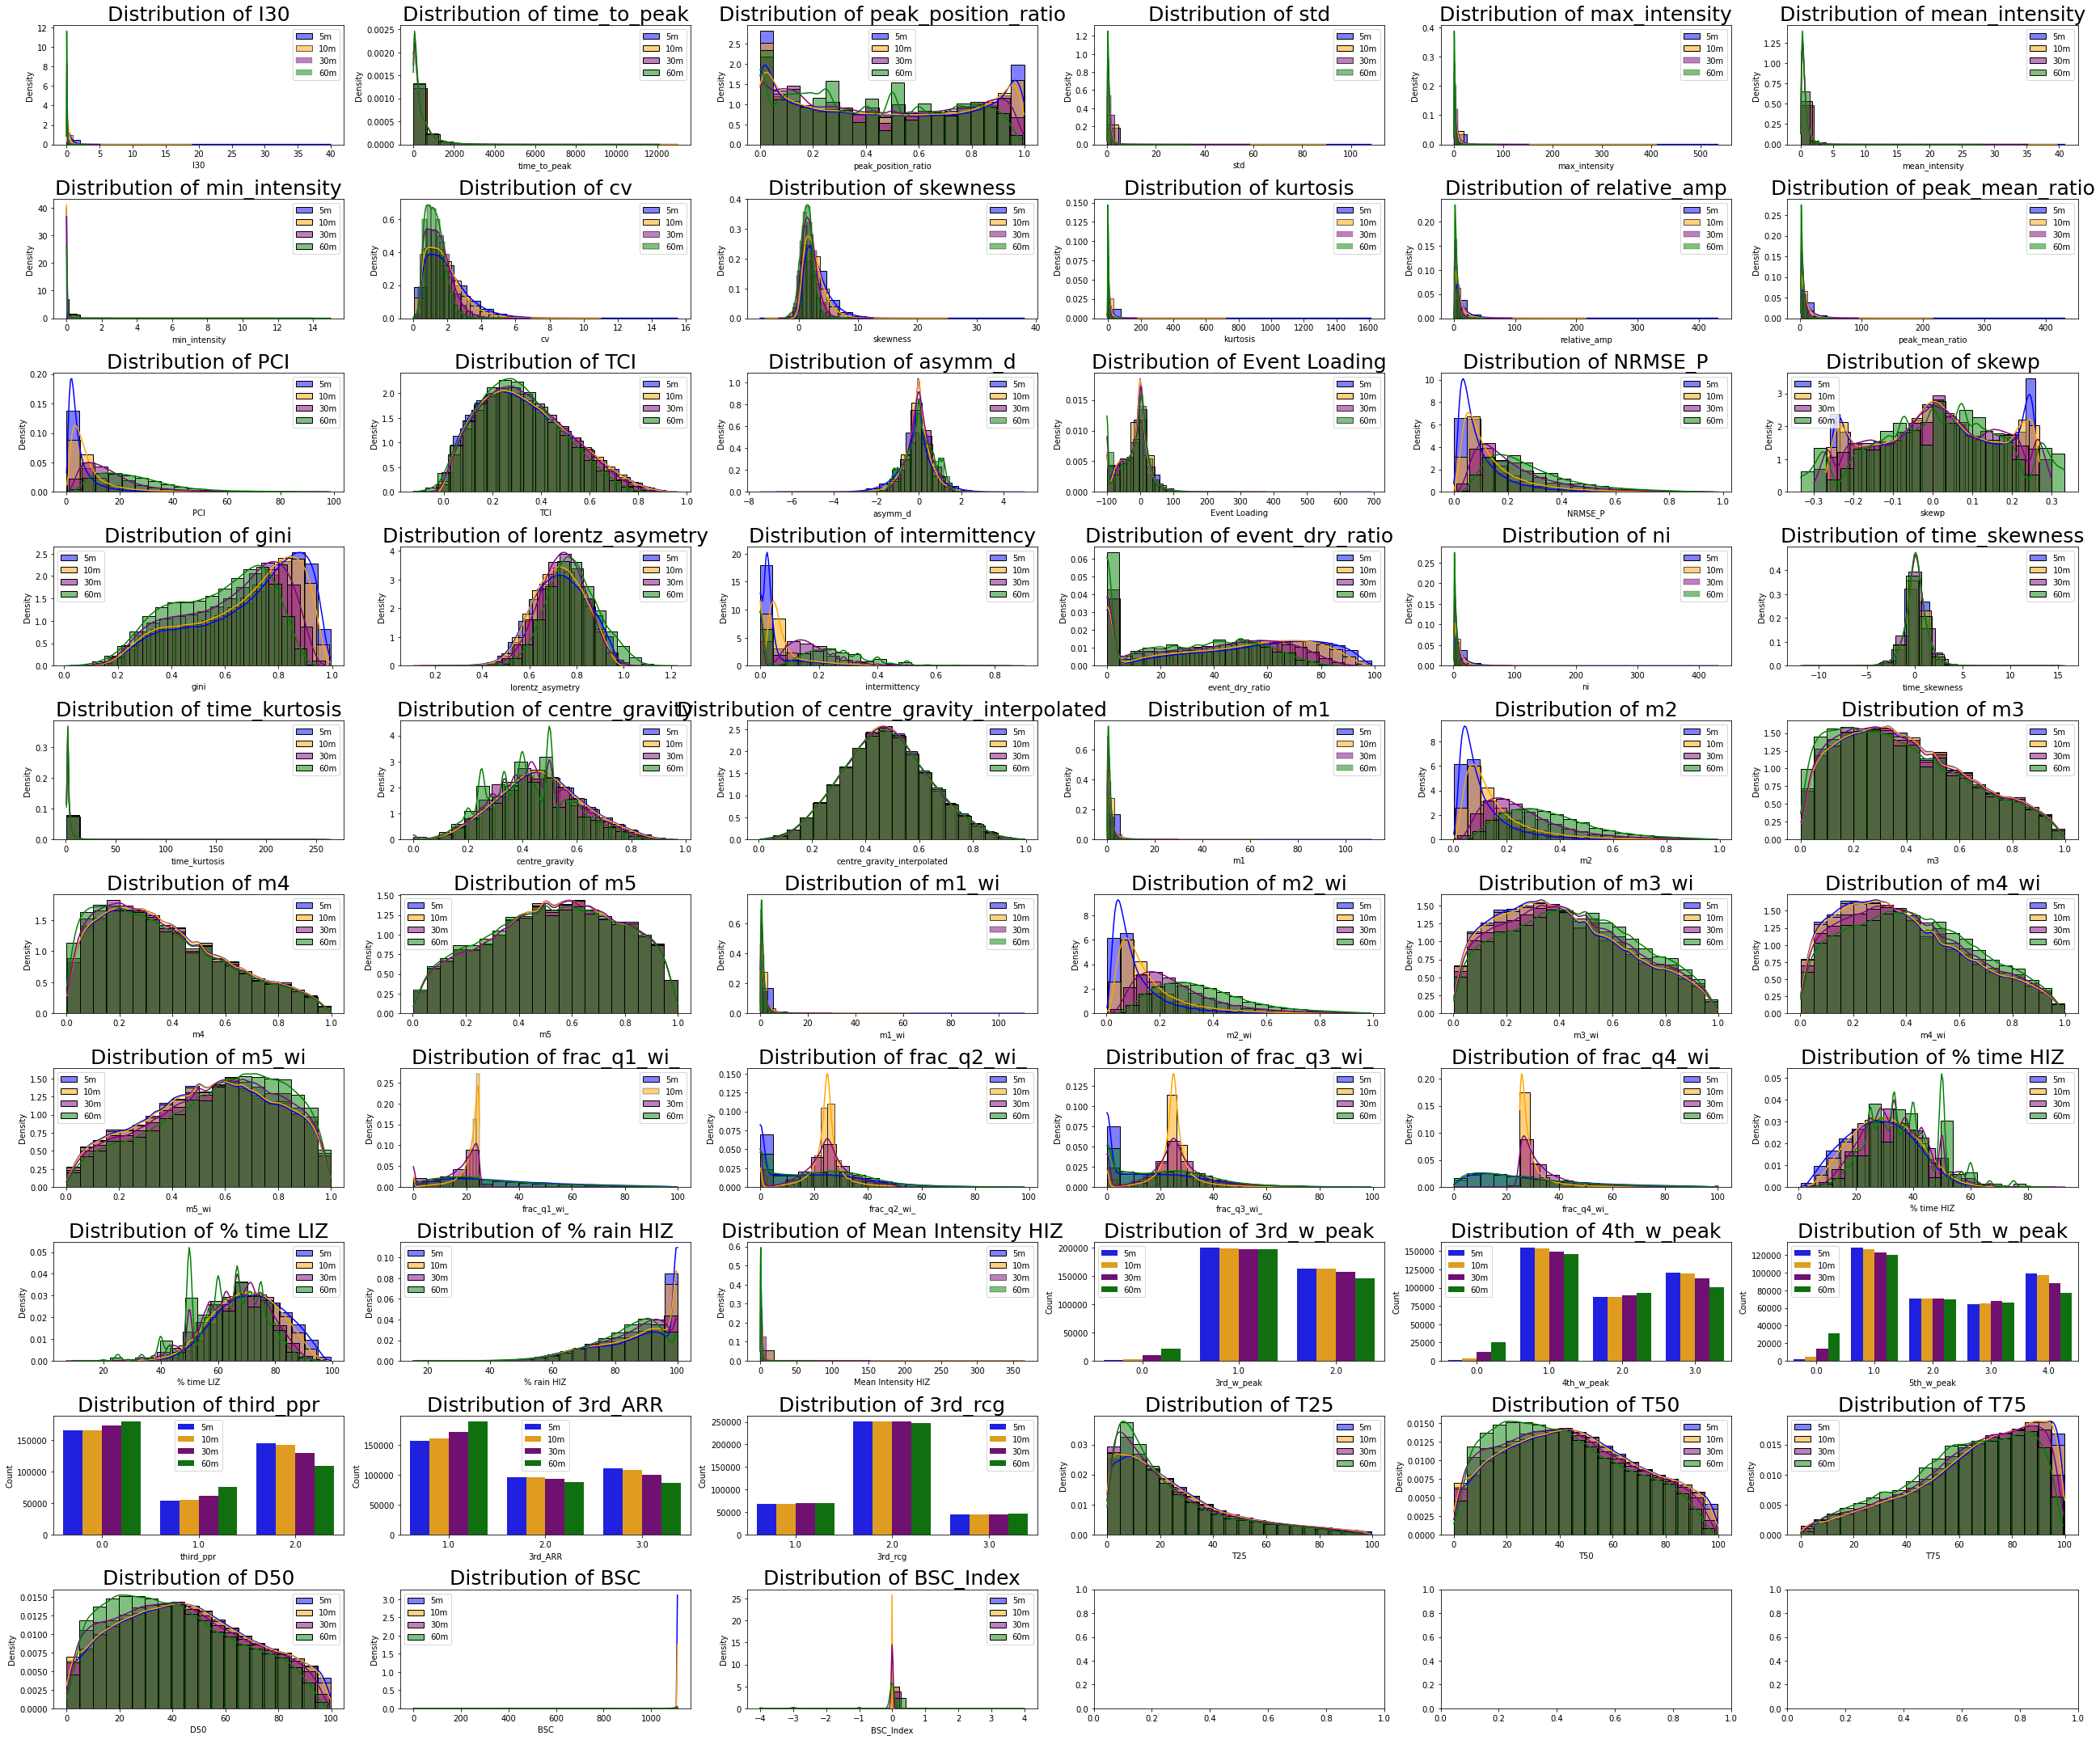

In [215]:
n_metrics = len(metric_columns)

# Define grid shape (e.g., 6 columns per row)
n_cols = 6
n_rows = int(np.ceil(n_metrics / n_cols))

# Define label order and consistent palette
label_order = list(resolutions.keys())
palette = {label: color for label, (df, color) in resolutions.items()}

# Combine all data into long format
plot_data = []
for label, (df, color) in resolutions.items():
    for metric in metric_columns:
        temp = df[[f"{metric}_{label}"]].copy()
        temp.columns = ['value']
        temp['metric'] = metric
        temp['label'] = label
        plot_data.append(temp)

long_df = pd.concat(plot_data)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 3), constrained_layout=True)
if len(metric_columns) == 1:
    axes = [axes]

axs = axes.flatten()

for idx, metric in enumerate(metric_columns):
    ax = axs[idx]
    metric_df = long_df[long_df['metric'] == metric]

    unique_vals = metric_df['value'].nunique()

    if unique_vals < 6:
        sns.countplot(
            data=metric_df,
            x='value',
            hue='label',
            palette=palette,
            hue_order=label_order,
            dodge=True,
            ax=ax
        )
        ax.set_ylabel("Count")
    else:
        for label in label_order:
            subset = metric_df[metric_df['label'] == label]
            sns.histplot(
                data=subset,
                x='value',
                stat='density',
                bins=20,
                alpha=0.5,
                color=palette[label],
                label=label,
                kde=True,
                ax=ax
            )
        ax.set_ylabel("Density")

    ax.set_title(f'Distribution of {metric}', fontsize=25)
    ax.set_xlabel(metric)

    # Set consistent legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    new_handles = []
    for lbl in label_order:
        if lbl in labels:
            i = labels.index(lbl)
            new_labels.append(lbl)
            new_handles.append(handles[i])
    ax.legend(new_handles, new_labels)

plt.tight_layout()
plt.show()
fig.savefig('../Figures/histograms.png', facecolor='white', edgecolor='white')


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


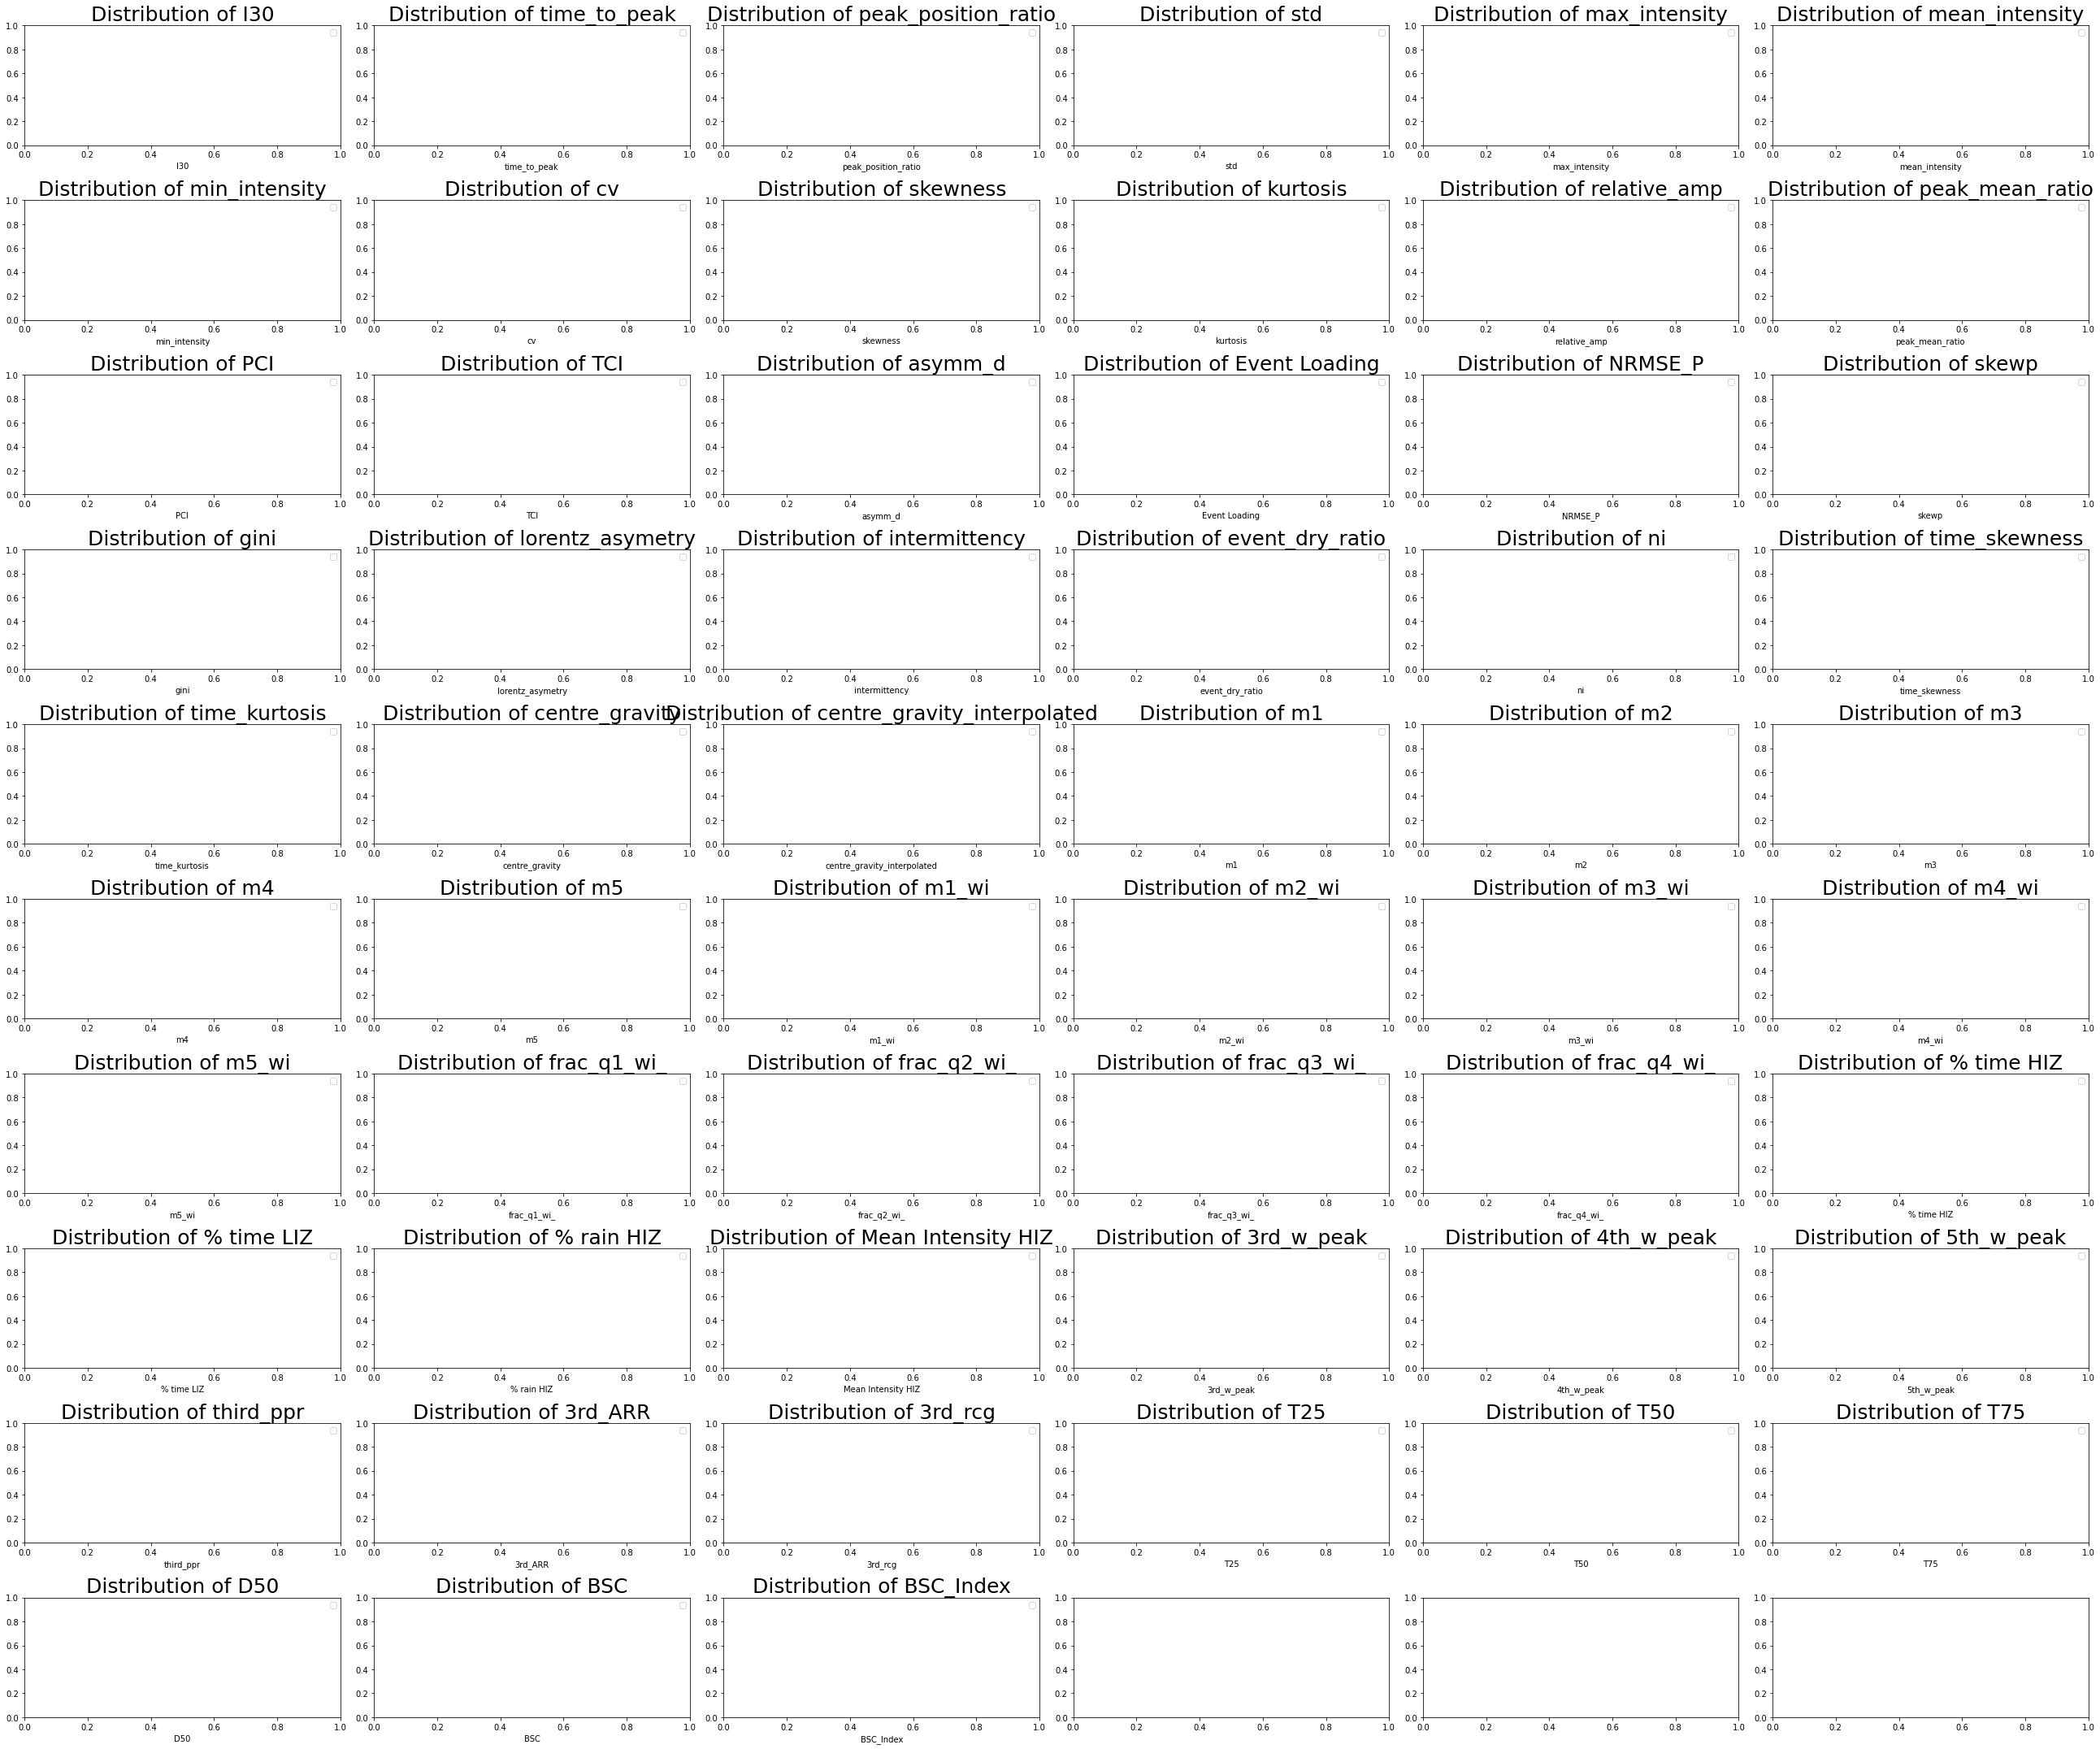

In [214]:
n_metrics = len(metric_columns)

# Define grid shape (e.g., 6 columns per row)
n_cols = 6
n_rows = int(np.ceil(n_metrics / n_cols))

# Define label order and consistent palette
label_order = list(resolutions.keys())
palette = {label: color for label, (df, color) in resolutions.items()}

# Combine all data into long format
plot_data = []
for label, (df, color) in resolutions.items():
    for metric in metric_columns:
        temp = df[[f"{metric}_{label}"]].copy()
        temp.columns = ['value']
        temp['metric'] = metric
        temp['label'] = label
        plot_data.append(temp)

long_df = pd.concat(plot_data)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 3), constrained_layout=True)
if len(metric_columns) == 1:
    axes = [axes]

axs = axes.flatten()

for idx, metric in enumerate(metric_columns):
    ax = axs[idx]
   

    ax.set_title(f'Distribution of {metric}', fontsize=25)
    ax.set_xlabel(metric)

    # Set consistent legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    new_handles = []
    for lbl in label_order:
        if lbl in labels:
            i = labels.index(lbl)
            new_labels.append(lbl)
            new_handles.append(handles[i])
    ax.legend(new_handles, new_labels)

plt.tight_layout()
plt.show()
fig.savefig('../Figures/histograms.png', facecolor='white', edgecolor='white')
